# Saudi Arabia Tour

This is an example of solving an open TSP problem to visit 14 major Saudi cities starting from KFUPM in Dhahran.

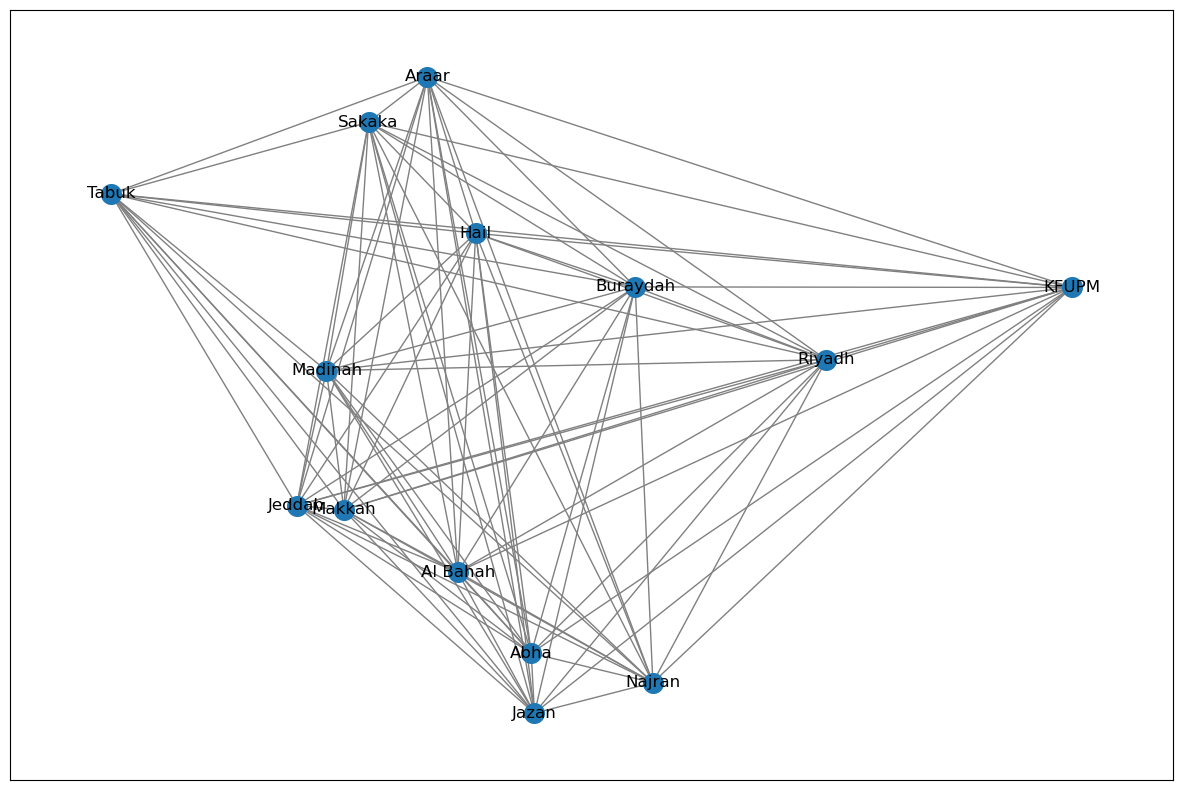

In [1]:
# Define the TSP problem
import pandas as pd
import networkx as nx
from collections import defaultdict
from haversine import haversine
import matplotlib.pyplot as plt

# latitude and longitude for major Saudi cities
cities = {
    'KFUPM': (26.3126, 50.1403),
    'Riyadh': (24.7136, 46.6753),
    'Buraydah': (26.3250, 43.9748),
    'Hail': (27.5114, 41.7208),
    'Araar': (30.9753, 41.0381),
    'Sakaka': (29.9697, 40.2064),
    'Tabuk': (28.3838, 36.5662),
    'Madinah': (24.4709, 39.6122),
    'Jeddah': (21.4858, 39.1925),
    'Makkah': (21.3891, 39.8579),
    'Al Bahah': (20.0129, 41.4677),
    'Abha': (18.2164, 42.5053),
    'Jazan': (16.8891, 42.5510),
    'Najran': (17.5650, 44.2236)
}


# create a haversine distance matrix based on latitude-longitude coordinates
distance_matrix = defaultdict(dict)
for ka, va in cities.items():
    for kb, vb in cities.items():
        distance_matrix[ka][kb] = 0.0 if kb == ka else haversine((va[0], va[1]), (vb[0], vb[1])) 
        

# convert distance diccionary into a dataframe        
distances = pd.DataFrame(distance_matrix)
city_names=list(distances.columns)
distances=distances.values

# Visualize the cities and then route

# Create a graph
G=nx.Graph()

for ka, va in cities.items():
    for kb, vb in cities.items():
        G.add_weighted_edges_from({(ka,kb, distance_matrix[ka][kb])})
        G.remove_edges_from(nx.selfloop_edges(G))
        
fig, ax = plt.subplots(figsize=(15,10))

# reverse lat and long for correct visualization
reversed_dict = {key: value[::-1] for key, value in cities.items()}

# Create an independent shallow copy of the graph and attributes
H = G.copy()

 
# Draw the network
ax=nx.draw_networkx(
    H,
    pos=reversed_dict,
    with_labels=True,
    edge_color="gray",
    node_size=200,
    width=1,
)

plt.show()

# Solving the TSP using simulated annealing

In [2]:
# !pip install simanneal 
import random
from simanneal import Annealer

class TravellingSalesmanProblem(Annealer):

    # pass extra data (the distance matrix) into the constructor
    def __init__(self, state, distance_matrix):
        self.distance_matrix = distance_matrix
        super(TravellingSalesmanProblem, self).__init__(state)  # important!

    def move(self):
        """Swaps two cities in the route."""
        # no efficiency gain, just proof of concept
        # demonstrates returning the delta energy (optional)
        initial_energy = self.energy()

        a = random.randint(0, len(self.state) - 1)
        b = random.randint(0, len(self.state) - 1)
        self.state[a], self.state[b] = self.state[b], self.state[a]

        return self.energy() - initial_energy

    def energy(self):
        """Calculates the length of the route."""
        e = 0
        for i in range(len(self.state)):
            e += self.distance_matrix[self.state[i-1]][self.state[i]]
        return e

In [3]:
# initial state, a randomly-ordered itinerary
init_state = list(cities)
random.shuffle(init_state)

tsp = TravellingSalesmanProblem(init_state, distance_matrix)
tsp.set_schedule(tsp.auto(minutes=0.2))
# since our state is just a list, slice is the fastest way to copy
tsp.copy_strategy = "slice"
state, e = tsp.anneal()

while state[0] != 'KFUPM':
    state = state[1:] + state[:1]  # rotate to start

print()
print("%i mile route:" % e)
print(" ➞  ".join(state))

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     4.90000       4751.71     7.55%     0.00%     0:00:01     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     4.90000       4751.71     7.27%     0.01%     0:00:05     0:00:00


4751 mile route:
KFUPM ➞  Buraydah ➞  Hail ➞  Araar ➞  Sakaka ➞  Tabuk ➞  Madinah ➞  Jeddah ➞  Makkah ➞  Al Bahah ➞  Abha ➞  Jazan ➞  Najran ➞  Riyadh


# Visualize the cities and the route

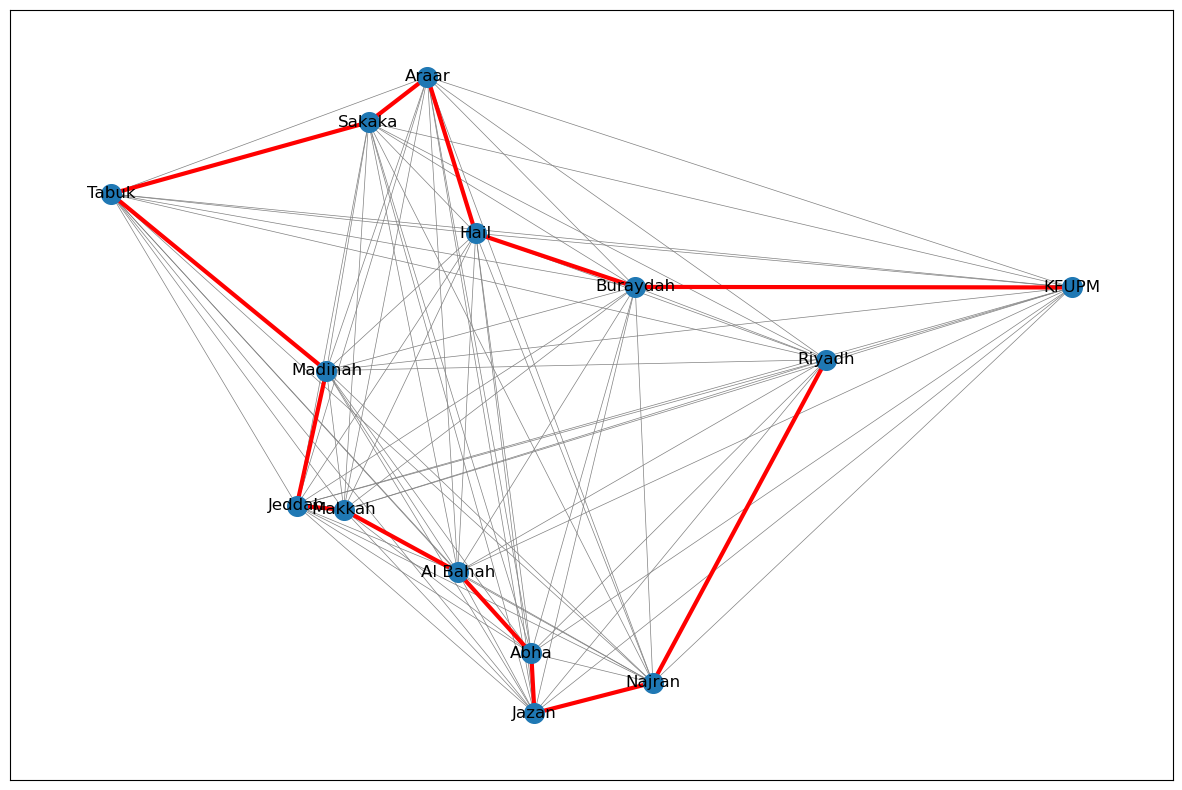

In [4]:
fig, ax = plt.subplots(figsize=(15,10))

# reverse lat and long for correct visualization
reversed_dict = {key: value[::-1] for key, value in cities.items()}

# Create an independent shallow copy of the graph and attributes
H = G.copy()

edge_list = list(nx.utils.pairwise(state))

# Draw closest edges on each node only
nx.draw_networkx_edges(H, pos=reversed_dict, edge_color="gray", width=0.5)

# Draw the route
ax=nx.draw_networkx(
    H,
    pos=reversed_dict,
    with_labels=True,
    edgelist=edge_list,
    edge_color="red",
    node_size=200,
    width=3,
)

plt.show()

# Visualize on a map

In [5]:
import folium
from folium.plugins import AntPath

tsp_coords = [cities[city] for city in state]

# Create a folium map centered on Saudi Arabia
saudi_map = folium.Map(location=[23.8859, 45.0792], zoom_start=6)

# Add cities to the map
for city, coords in cities.items():
    folium.Marker(
        location=coords,
        popup=city,
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(saudi_map)

# Create the edge list
edge_list = list(nx.utils.pairwise(state))

# Add edges to the map using AntPath for animation
for start_city, end_city in edge_list:
    AntPath(
        [cities[start_city], cities[end_city]], color="red", weight=4, opacity=0.7
    ).add_to(saudi_map)

# Save map to an HTML file and display
saudi_map.save("saudi_route_map.html")

# Display the folium map in the notebook
saudi_map

# Another solution using optalgotools

In [6]:
from optalgotools.algorithms import SimulatedAnnealing
from optalgotools.problems import TSP

pairwise_distances = distances
tsp_KSA = TSP(dists=pairwise_distances, gen_method='insert', init_method='greedy')

sa=SimulatedAnnealing(max_iter=10000, max_iter_per_temp=10000, initial_temp=10000000, final_temp=0.0001, cooling_schedule='geometric', cooling_alpha=0.9, debug=1)
sa.run(tsp_KSA)

Simulated annealing is initialized:
current value = 6092.810161654334, current temp=10000000
Simulated Annealing is done: 
curr iter: 242, curr best value: 5540.732565761833, curr temp:9.385226860283622e-05, curr best: sol: [0, 11, 12, 13, 10, 9, 8, 7, 6, 5, 4, 3, 1, 2, 0]


In [7]:
# Retreive the city names from the index
city_names = list(cities.keys())
cities_in_path = [city_names[i] for i in sa.s_best]

tsp_path = " ➞ ".join(cities_in_path)
print(tsp_path)

KFUPM ➞ Abha ➞ Jazan ➞ Najran ➞ Al Bahah ➞ Makkah ➞ Jeddah ➞ Madinah ➞ Tabuk ➞ Sakaka ➞ Araar ➞ Hail ➞ Riyadh ➞ Buraydah ➞ KFUPM


In [8]:
# helper function that takes a folium map and plot an antpath based on the route of the osmids 
def draw_route(G, route, m):
    ways_frame = ox.graph_to_gdfs(G)[1]    
    path = []
    for u, v in zip(route[0:], route[1:]):
        try:
            geo = (ways_frame.query(f'u == {u} and v == {v}').to_dict('list')['geometry'])
            m_geo = min(geo,key=lambda x:x.length)
        except:
            geo = (ways_frame.query(f'u == {v} and v == {u}').to_dict('list')['geometry'])
            m_geo = min(geo,key=lambda x:x.length)
        x, y = m_geo.coords.xy
        points = map(list, [*zip([*y],[*x])])
        path.extend([*points][:-1])

    folium.plugins.AntPath(
        locations = path,
        dash_array=[1, 10],
        delay=1000,
        color='red',
        pulse_color='black'
    ).add_to(m)

    return m

In [9]:
# A helper function that takes the graph and it creates a map and draw a path between all locations in it 
def draw_map_path(G, path, locations, routes):
    m = folium.Map(location=locations.mean().to_list(), zoom_start=10, scrollWheelZoom=False, dragging=True)

    route = []

    locationlist = locations.values.tolist()
    num_loc = len(locationlist)
    for i in range(num_loc):
        store_id = path[i]

        folium.Marker(location=locationlist[store_id], icon=folium.Icon(color='white', icon_color='white')).add_to(m)
        icon = folium.DivIcon(
            icon_size=(150,36),
            icon_anchor=(12,40),
            html="""<span class="fa-stack " style="font-size: 12pt" >
                    <span class="fa fa-circle-o fa-stack-2x" style="color : blue"></span>
                    <strong class="fa-stack-1x">
                         {:d}
                    </strong>
                </span>""".format(i)
        )
        folium.Marker(location=locationlist[store_id], icon=icon).add_to(m)
        
        if i == 0:
            store_id_1 = path[num_loc-1]
        else:
            store_id_1 = path[i-1]

        shortest_route = routes[store_id_1][store_id]
        
        if i == num_loc-1:
            route.extend(shortest_route)
        else:
            route.extend(shortest_route[:-1])

    draw_route(G, route, m=m)
        
    return m

In [10]:
# Extract city names from the dictionary
cities_in_path = list(cities.keys())

print(cities_in_path)

['KFUPM', 'Riyadh', 'Buraydah', 'Hail', 'Araar', 'Sakaka', 'Tabuk', 'Madinah', 'Jeddah', 'Makkah', 'Al Bahah', 'Abha', 'Jazan', 'Najran']
